This notebook consumes taxonomically annotated full length 16S sequences, and compares the observed relative abundances to taxonomic annotations from 16S V4 sequences previously generated from extracted DNA from the same samples. 

In [2]:
%matplotlib inline
import qiime2
import matplotlib.pyplot as plt
import seaborn as sns
import biom
import pandas as pd
import numpy as np
import scipy.stats as ss
import redbiom.fetch
from qiime2.plugins import feature_classifier

In [4]:
# these files are generated upstream by q2-over-16S.sh
operon_tax = qiime2.Artifact.load('annotations/q2_seqs-seqs-dn-99-classified.qza').view(pd.DataFrame)
operon_biom = qiime2.Artifact.load('annotations/q2_seqs-table-dn-99.qza').view(biom.Table)

In [5]:
operon_biom.filter({i for i in operon_biom.ids() if i.startswith('10317')}, inplace=True).remove_empty()
operon_biom.update_ids({i: i.rsplit('_', 1)[0] for i in operon_biom.ids()}, inplace=True)

1583 x 70 <class 'biom.table.Table'> with 9586 nonzero entries (8% dense)

In [21]:
context = 'Deblur-Illumina-16S-V4-150nt-780653'
base_biom_raw, base_ambiguities = redbiom.fetch.data_from_samples(context, operon_biom.ids())

In [79]:
base_biom_clean = base_biom_raw.collapse(lambda i, m: base_ambiguities[i], norm=False)
base_biom_clean.filter(lambda v, i, m: v.sum() >= 2, axis='observation').remove_empty()

4078 x 70 <class 'biom.table.Table'> with 12385 nonzero entries (4% dense)

In [80]:
base_biom_clean

4078 x 70 <class 'biom.table.Table'> with 12385 nonzero entries (4% dense)

In [81]:
len(set(base_biom_clean.ids()) & set(operon_biom.ids()))

70

In [82]:
operon_biom.filter(set(base_biom_clean.ids())).remove_empty()

1583 x 70 <class 'biom.table.Table'> with 9586 nonzero entries (8% dense)

In [83]:
operon_biom.norm()
base_biom_clean.norm()

4078 x 70 <class 'biom.table.Table'> with 12385 nonzero entries (4% dense)

In [84]:
base_biom_fna = pd.Series(base_biom_clean.ids(axis='observation'), 
                          index=base_biom_clean.ids(axis='observation'))
base_biom_fna_ar = qiime2.Artifact.import_data('FeatureData[Sequence]', base_biom_fna)
ref = qiime2.Artifact.load('gg-13-8-99-515-806-nb-classifier.qza')
base_tax_ar, = feature_classifier.actions.classify_sklearn(reads=base_biom_fna_ar, classifier=ref, n_jobs=4)
base_tax = base_tax_ar.view(pd.DataFrame)

In [85]:
base_tax = base_tax_ar.view(pd.DataFrame)

In [86]:
operon_tax['genus'] = [v.split('; ')[5] if v.count(';') > 5 else None for v in operon_tax.Taxon]
base_tax['genus'] = [v.split('; ')[5] if v.count(';') > 5 else None for v in base_tax.Taxon]

In [87]:
len(operon_tax['genus'].unique())

104

In [88]:
len(base_tax['genus'].unique())

155

In [89]:
operon_tax_overlap = operon_tax.loc[list(operon_biom.ids(axis='observation'))]
base_tax_overlap = base_tax.loc[list(base_biom_clean.ids(axis='observation'))]

overlap = (set(base_tax_overlap['genus'].unique()) & \
           set(operon_tax_overlap['genus'].unique()) - \
          {None, 'g__', np.nan})
len(overlap)

82

In [90]:
operon_tax_overlap = operon_tax_overlap[operon_tax_overlap.genus.isin(overlap)].copy()
base_tax_overlap = base_tax_overlap[base_tax_overlap.genus.isin(overlap)].copy()

In [91]:
operon_biom_overlap = operon_biom.filter(set(operon_tax_overlap.index), axis='observation', 
                                         inplace=False).remove_empty()
base_biom_clean_overlap = base_biom_clean.filter(set(base_tax_overlap.index), axis='observation', 
                                                 inplace=False).remove_empty()

In [92]:
def op_partition_f(i, m):
    return operon_tax_overlap.loc[i]['genus']
operon_biom_overlap_genus = operon_biom_overlap.collapse(op_partition_f, axis='observation', norm=False)

In [93]:
def ba_partition_f(i, m):
    return base_tax_overlap.loc[i]['genus']
base_biom_clean_overlap_genus = base_biom_clean_overlap.collapse(ba_partition_f, axis='observation', norm=False)

In [94]:
operon_biom_overlap_genus.shape

(82, 70)

In [95]:
base_biom_clean_overlap_genus.shape

(82, 70)

In [96]:
operon_biom_overlap_genus = operon_biom_overlap_genus.sort_order(base_biom_clean_overlap_genus.ids())
operon_biom_overlap_genus = operon_biom_overlap_genus.sort_order(base_biom_clean_overlap_genus.ids(axis='observation'),
                                                                 axis='observation')

In [97]:
data = []
genera = base_biom_clean_overlap_genus.ids(axis='observation')
for v, i, m in base_biom_clean_overlap_genus.iter():
    values = v[v > 0]
    obs = genera[v > 0]
    for rel, o in zip(values, obs):
        data.append(('16S', i, o, rel))
for v, i, m in operon_biom_overlap_genus.iter():
    values = v[v > 0]
    obs = genera[v > 0]
    for rel, o in zip(values, obs):
        data.append(('Operon', i, o, rel))
data = pd.DataFrame(data, columns=['Type', 'Sample', 'Genus', 'Relative-abundance'])

In [98]:
data

,Type,Sample,Genus,Relative-abundance
0,16S,10317.000022413,g__Blautia,0.064584
1,16S,10317.000022413,g__Oscillospira,0.018038
2,16S,10317.000022413,g__Coprococcus,0.024989
3,16S,10317.000022413,g__Clostridium,0.005279
4,16S,10317.000022413,g__Ruminococcus,0.210999
...,...,...,...,...
3246,Operon,10317.000051183,g__WAL_1855D,0.005804
3247,Operon,10317.000051183,g__Haemophilus,0.000415
3248,Operon,10317.000051183,g__ph2,0.001658
3249,Operon,10317.000051183,g__1-68,0.000829


Spearman: r=0.527, p=1.449e-80
Pearson: r=0.553, p=4.555e-90


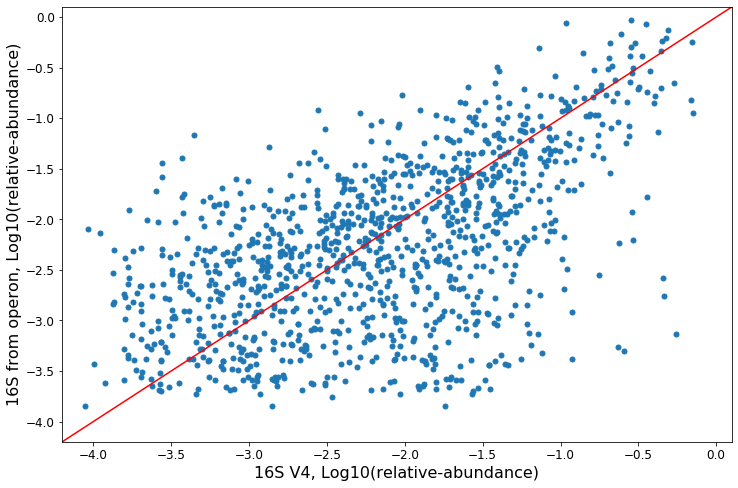

In [99]:
xs = []
ys = []
for (id_, genus), grp in data.groupby(['Sample', 'Genus']):
    a = grp[grp.Type == '16S']
    b = grp[grp.Type == 'Operon']

    if len(a):
        x = np.log10(a.iloc[0]['Relative-abundance'])
    else:
        # x = 0
        continue
        
    if len(b):
        y = np.log10(b.iloc[0]['Relative-abundance'])
    else:
        # y = 0
        continue
        
    xs.append(x)
    ys.append(y)

fig = plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, s=25)
plt.ylabel('16S from operon, Log10(relative-abundance)', fontsize=16)
plt.xlabel('16S V4, Log10(relative-abundance)', fontsize=16)
plt.plot([-5, 0.2], [-5, 0.2], c='r')
ax = plt.gca()
ax.set_xlim(-4.2, 0.1)
ax.set_ylim(-4.2, 0.1)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig('genus_correlation.pdf')

print("Spearman: r=%0.3f, p=%0.3e" % ss.spearmanr(xs, ys))
print("Pearson: r=%0.3f, p=%0.3e" % ss.pearsonr(xs, ys))

Figure SX. A scatter plot of the relative abundances of bacterial genera within samples. Each point represents the observed relative abundance from Earth Microbiome Project 16S V4 derived data, and the observed relative abundance of the full operon data based on taxonomic annotation of the full length 16S. 